In [7]:
import os
from typing import Tuple
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.io.image import read_image
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from data.shift_dataset import pedestrian_filter_10_15k, no_pedestrian_filter
from utils.helper_functions import ShiftOODDataModule
from data.coco_dataset import COCODataset, USED_CATEGORIES

In [15]:
ds = ShiftOODDataModule("./datasets/SHIFT", 512, "./datasets/COCO2014", 320, 8, no_pedestrian_filter, pedestrian_filter_10_15k, "ood_pedestrian", 0, 1, False, 3, 8)

loading annotations into memory...
Done (t=3.41s)
creating index...
index created!


In [27]:
img, lbl = ds.train_dataset[0]

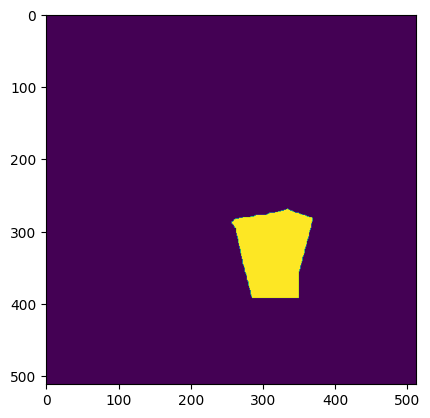

In [28]:
plt.imshow(lbl==101)

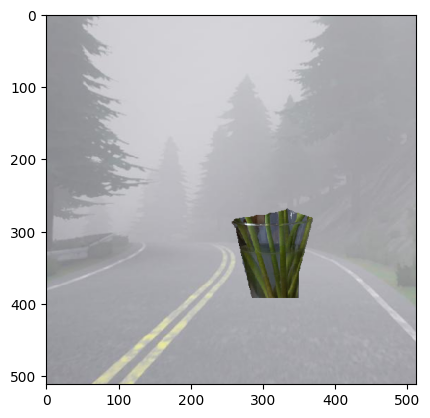

In [29]:
plt.imshow(img.permute((1, 2, 0)))

In [3]:
for i in range(len(ds)):
    img, mask = ds[i]
    if img.shape[0]*img.shape[1]*img.shape[2] == 0:
        print(i, img.shape)
        break
    if i%2000 == 0:
        print(i, end="\r")

No possible object in image torch.Size([3, 480, 640])
No possible object in image torch.Size([3, 480, 640])


In [5]:
i

36390